In [1]:
import math
import numpy as np
import pandas as pd
import scipy as sc

import matplotlib.pyplot as plt
from scipy.integrate import quad, trapz, simps, cumtrapz

%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Расчет

Некоторые константы

In [2]:
Q_EC_76As=0.9233 #in MeV
Z_76As=33

g_a_g_v=1.297 #ratio of vector and axial coupling constants

BS05_OP_pep_ampl=1.42e8
pep_en=1.442 #MeV

S_n = 7.328 #энергия отрыва нейтрона

total_GT = 19.89

Функция для расчета порога реакции

In [3]:
def Q_k_func(E_k, Q_EC):
    #Считаем порог реакции, E_k - энергия возбужденного состояния в BGT
    #E_k in KeV
    return Q_EC+E_k/1000

Привиденная энергия вылетающего электрона: $\epsilon_e = \frac{E_{\nu}-Q_k}{m_e} + 1$

In [4]:
def e_e_func(E_nu, E_k, Q_EC):
    #Считаем привиденную энергию вылетающего электрона. Если энергия налетающего нейтрино E_nu
    #меньше порога, возвращаем 0 для обнуления итогового сечения
    #E_nu in MeV
    q=Q_k_func(E_k, Q_EC) #порог реакции
    if E_nu>q: return 1+(E_nu-q)/0.511
    else: return 0 

Привиденный импульс электрона: $\pi_e=\sqrt{\epsilon_e^2 -1}$

In [5]:
def Pi_e_func(e_e):
    #Привиденный импульс электрона, вычисляется через привиденную энергию; ** означает степень  
    if e_e>1: return math.sqrt(e_e**2 - 1)
    else: return 0

In [6]:
def integrate_func(a, b, x, y):
    return np.sum( np.interp(x=np.arange(a, b, 0.001), xp=x, fp=y ) * 0.001 )

### Fermi-function from Numerical Tables for Beta-Decay and Electron Capture

Ферми функия из оцифрованных немецких таблиц. Считываем данные

In [7]:
Fermi_func_new_data = pd.read_excel('../../fermi_func_tables/from_1968/13.xlsx')
Fermi_func_new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 14 columns):
P              49 non-null float64
F0L0           49 non-null float64
L0             48 non-null object
1z             48 non-null float64
13             48 non-null float64
ELECTRON
14    48 non-null float64
Z= 33
Izt      48 non-null float64
A= 77          48 non-null float64
A,             48 non-null float64
A2             48 non-null float64
VI2            48 non-null float64
912            48 non-null float64
12             48 non-null float64
Unnamed: 13    48 non-null float64
dtypes: float64(13), object(1)
memory usage: 5.4+ KB


Функция для расчета интерполированного значения. В таблице дана зависимость от импульса вылетающего электрона. Переводим ее в зав-ть от энергии электрона

In [8]:
e_e3 = np.sqrt( np.square( Fermi_func_new_data['P'].values ) + 1 ) #энергия вылетающего электрона
def num_tables_func(x):
    #x in units of mc^2
    return np.interp(x=x, xp=e_e3, fp=Fermi_func_new_data['F0L0'].values )

### B(GT) data

E_x до 5 МэВ!!!

In [9]:
BGT=pd.read_csv('../B(GT) peaks processing//clear_B(GT).csv') #таблица со значениями B(GT)
BGT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73 entries, 0 to 72
Data columns (total 5 columns):
Unnamed: 0        73 non-null int64
Ex                73 non-null float64
Jpi               73 non-null object
diff cross-sec    73 non-null float64
B(GT)             73 non-null float64
dtypes: float64(3), int64(1), object(1)
memory usage: 2.9+ KB


In [10]:
BGT['B(GT)'] = BGT['B(GT)']/10 #делим на 10 т.к. в таблице все значения домножены на 10

In [11]:
BGT = BGT[ BGT['Jpi'] == '1' ] #отбираем уравни с Jpi == 1

#### table B(GT) summ

In [12]:
table_BGT = np.sum(BGT['B(GT)'].values)
print(table_BGT)

1.544


### BS05_OP flux

In [13]:
BS05_OP=pd.read_csv('../Vyborov_results/Fluxes/AllFluxes_BS05(OP).csv', sep=';')
BS05_OP.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
energy    2000 non-null float64
pp        2000 non-null float64
hep       2000 non-null float64
N         2000 non-null float64
F         2000 non-null float64
O         2000 non-null float64
B         2000 non-null float64
dtypes: float64(7)
memory usage: 109.5 KB


создаем словарь, где ключ - название канала нейтрино (напр O или F), значение - двумерный массив, характеризующий интеполированные значения энергии и амплитуды для даннаго канала нейтрино 

In [14]:
all_fluxes_step = 0.01
Energy_all_fluxes = np.arange(0,20,0.01) #массив характеризующий шаги интегрирования

In [15]:
BS05_OP_dict = {}
for elem in list(BS05_OP.columns)[1:]:
    BS05_OP_dict.update({ elem : 
                        np.interp(x=Energy_all_fluxes, xp=BS05_OP['energy'], 
                                  fp=BS05_OP[elem] ) })

### Cross-section and total rate

### Расчет сечения с учетом только дискретных уровней 

Сечение по Иджири $\sigma_k={(10^{-44}\ cm^2)}\times 1.597\cdot \epsilon_e \pi_e m_e^2 F(Z,E_e) [B(F)_k + (\frac{g_a}{g_v})^2 B(GT)_k] $ 

In [16]:
g_a_g_v_square = math.pow(g_a_g_v,2)
m_e_square = math.pow(0.511,2)

In [17]:
#расчет сечения до энергии возбуждения 5 МэВ
def sigma_k_less5(E_nu, E_k, BGT_k, Z, Q_EC):
    #E_k in kev
    #сечение k-го возб. состояния по Иджири
    e_e=e_e_func(E_nu, E_k, Q_EC) #энергия вылетающего электрона
    Pi_e=Pi_e_func(e_e) #его импульс
    F_col=num_tables_func(e_e) #значение ферм-функции при такой энергии
    return 1.597*m_e_square*e_e*Pi_e*F_col*g_a_g_v_square*BGT_k

In [18]:
#функция расчета свертки сечения с потоком
def rate_calc(sigma):
    
    #const = 1.597*math.pow(10,-44)
    const = math.pow(10,-44)

    sigma_total = np.array(sigma) * const
    
    rate_total = 0
    
    for elem in list(BS05_OP_dict.keys()):
        rate = sum(BS05_OP_dict[elem]*sigma_total*all_fluxes_step) * math.pow(10,36)
        print(elem, ' ', rate)
        rate_total+=rate
        
    sigma_pep = np.interp(pep_en, xp=Energy_all_fluxes, fp=sigma_total)
    rate_pep = BS05_OP_pep_ampl*sigma_pep*math.pow(10,36)
    print('pep', ' ', rate_pep)
    
    rate_total+=rate_pep
    print('rate_total',' ', rate_total)
        
#ВНИМАНИЕ: в расчетах pep не учитывается

    Считаем свертку потока с сечением. 
    BS05_OP_dict[elem] - массив со значениями амплитуды потока нейтрино для канала elem.
    sigma - массив со значениями суммарного сечения.
    all_fluxes_step - шаг интегрирования.
    math.pow(10,36) - для получения итогового значения в SNU. 

In [19]:
sigma_less5=[sum([sigma_k_less5(E_nu, E_k, BGT_k, Z_76As, Q_EC_76As) 
                  for (BGT_k, E_k) in zip(BGT['B(GT)'].values, BGT['Ex'].values)]) 
             for E_nu in Energy_all_fluxes]

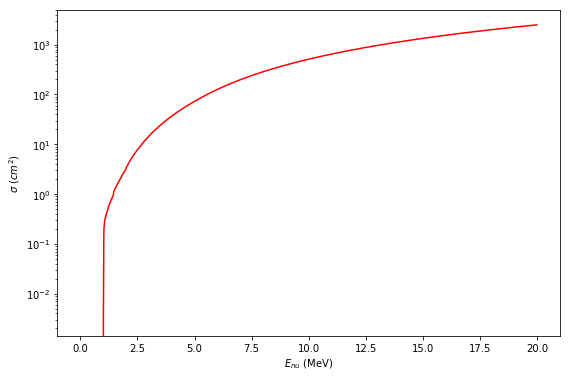

In [20]:
plt.figure(figsize=(9,6))
plt.plot(Energy_all_fluxes, sigma_less5, c='r')
plt.xlabel('$E_{nu}$ (MeV)')
plt.ylabel('$\sigma$ $(cm^2)$')
plt.yscale('log')
#plt.title('Сечение с учетом только дискретных состояний')

In [21]:
rate_calc(sigma_less5)

pp   0.0
B   13.542307922140907
F   0.021059736624544217
O   0.8275492449418691
hep   0.04510635720663797
N   0.10198118176409476
pep   1.3685712782859079
rate_total   15.906575720963959


### Расчет сечения с учетом только best_fit


(0, 6)

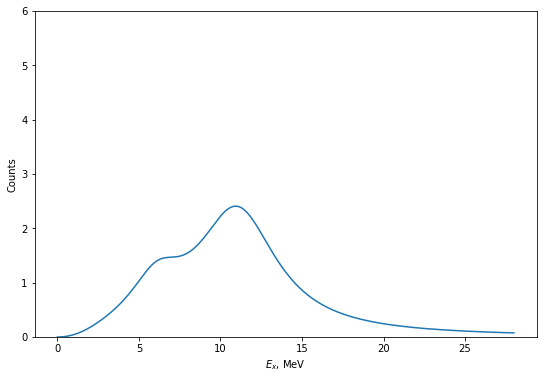

In [22]:
best_fit = pd.read_csv('fit_1PR-no74Ge.csv')
#best_fit = pd.read_csv('2pigmy_best_fit-SDR-IAS-QFC.csv')

plt.figure(figsize=(9,6))
plt.plot(best_fit['x'].values, best_fit['y'].values)
plt.xlabel('$E_x$, MeV')
plt.ylabel('Counts')
plt.ylim(0,6)

In [23]:
#функция для отрезки резонансов выше энергии отрыва
def border_func(x_data, y_data, border):
    a=np.where(x_data<border)
    #print(len(a[0]), len(x_data)-len(a[0]), len(x_data), a[0])
    return np.hstack(( y_data[a], np.zeros(len(x_data)-len(a[0])) ))


def border_func2(x_data, y_data, border_l, border_r):
    a=np.where(x_data<border_r)
    b=np.where(x_data>border_l)
    temp_y = np.hstack(( y_data[a], np.zeros(len(x_data)-len(a[0])) ))
    #print(len(a[0]), len(x_data)-len(a[0]), len(x_data), a[0])
    return np.hstack((np.zeros((b[0][0])), temp_y[b]))

Text(0.5,0,'Ex')

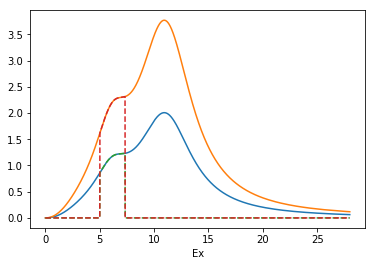

In [27]:
y_19 = best_fit['y'].values / trapz(best_fit['y'].values, best_fit['x'].values) \
* (total_GT-table_BGT)
y_36 = best_fit['y'].values / trapz(best_fit['y'].values, best_fit['x'].values) \
* (36-table_BGT)

#y_best_fit_border = border_func(best_fit['x'].values, y_best_fit, S_n)
y_19_2border = border_func2(best_fit['x'].values, y_19, 5, S_n)
y_36_2border = border_func2(best_fit['x'].values, y_36, 5, S_n)

#y_best_fit_border5 = border_func(best_fit['x'].values, y_best_fit, 5)


plt.plot(best_fit['x'].values, y_19)
plt.plot(best_fit['x'].values, y_36)
#plt.plot(best_fit['x'].values, y_best_fit_border, ls='-.')
plt.plot(best_fit['x'].values, y_19_2border, ls='--')
plt.plot(best_fit['x'].values, y_36_2border, ls='--')
#plt.plot(best_fit['x'].values, y_best_fit_border5, ls=':')
plt.xlabel('Ex')

In [28]:
total_GT

19.89

Сечение для непрерывной части

$\sigma = {(10^{-44}\ cm^2)} \times \int^{z-Q}_{0} {1.597 \cdot (\frac{g_a}{g_v})^2 \cdot \sqrt{(z-Q-x+0.511)^2-0.511^2} \cdot (z-Q-x+0.511) \cdot S_{GTR}(x) \cdot F(z-Q-x+0.511)} dx $ 


In [29]:
#введем новую переменную p = z - Q
def sigma_k_GTR(x, p, x_data, y_data):
    e_energy = p - x + 0.511
    return 1.597*g_a_g_v_square*np.sqrt(e_energy**2-m_e_square)*e_energy\
    *np.interp(x,xp=x_data,fp=y_data)*num_tables_func(e_energy/0.511) 


In [30]:
#разбиваем интервал интегрирования на субинтервалы
def intervals(a,b,n):
    c=np.linspace(a,b,num=n)
    return [[c[i], c[i+1]] for i in range(len(c)-1)]

In [31]:
#считаем сечение
def cross_sec(a,b, sigma_func, shape_x, shape_y, int_num=50):
    borders_list = intervals(a,b, int_num)
    #return sum([quad(sigma_func, i[0],i[1], args=(b,shape_x, shape_y))[0] for i in borders_list])
    return sum([sc.integrate.fixed_quad(sigma_func, i[0],i[1], args=(b,shape_x, shape_y))[0] for i in borders_list])
    #return sum([sc.integrate.romberg(sigma_func, i[0],i[1], args=(b,shape_x, shape_y)) for i in borders_list])

### norm 19

In [33]:
p_list = np.arange(0,20, 0.1) #p = z - Q

sigma_19_2border_temp = [cross_sec(0,p, sigma_k_GTR, best_fit['x'].values, y_19_2border, 200) for p in p_list]

sigma_19_2border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_19_2border_temp)
#sigma_more5_1 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_more5_temp1)

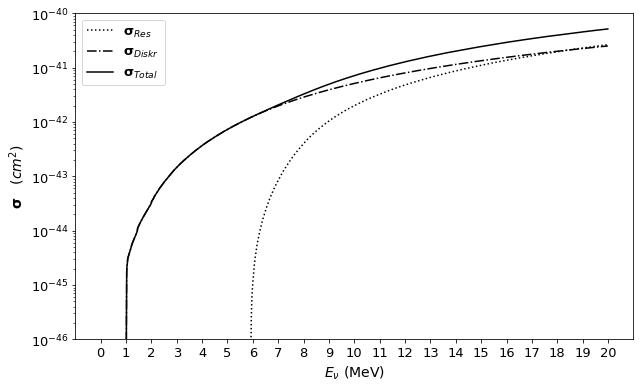

In [53]:
plt.figure(figsize=(10,6))
const = math.pow(10,-44)
plt.plot(Energy_all_fluxes, sigma_19_2border_full * const, ls=':', c='black', 
         label='$\mathbf{\sigma}_{Res}$')
plt.plot(Energy_all_fluxes, np.array(sigma_less5) * const, ls='-.', c='k', 
         label='$\mathbf{\sigma}_{Diskr} $')
plt.plot(Energy_all_fluxes, (np.array(sigma_less5)+sigma_19_2border_full) * const, 
         ls='-', c='k', label='$\mathbf{\sigma}_{Total} $')
plt.xlabel('$E_{\\nu}$ (MeV)', fontsize=14)
plt.ylabel('$\mathbf{\sigma} \quad (cm^2)$', fontsize=14)

plt.yscale('log')
plt.legend(fontsize=13)
#plt.grid(True, which="both",ls="-", color='0.8')
plt.ylim(10**(-46), 10**(-40))
plt.xticks(np.arange(0,21))
plt.tick_params(labelsize=13)
#plt.title('Сечение с учетом только дискретных состояний')

#plt.savefig('cross_section_best_fit_5_Sn_norm19.png', format='png', dpi=500)

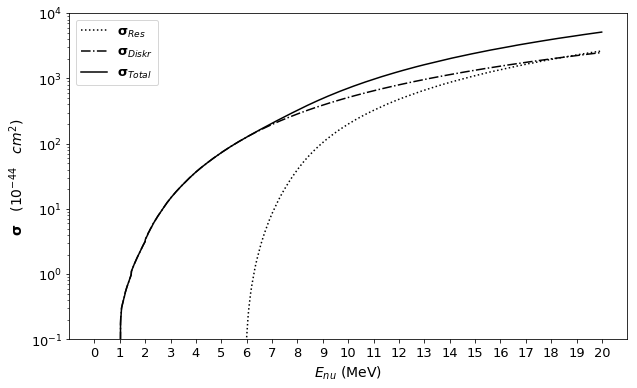

In [55]:
plt.figure(figsize=(10,6))
#plt.plot(Energy_all_fluxes, sigma_best_fit_full, ls=':', c='r', label='cross-section with only best_fit_full')
#plt.plot(Energy_all_fluxes, sigma_best_fit_Sn, ls=':', c='orange', label='cross-section with only best_fit_Sn')
plt.plot(Energy_all_fluxes, sigma_19_2border_full, ls=':', c='black', 
         label='$\mathbf{\sigma}_{Res}$')
plt.plot(Energy_all_fluxes, sigma_less5, ls='-.', c='k', 
         label='$\mathbf{\sigma}_{Diskr} $')
plt.plot(Energy_all_fluxes, sigma_less5+sigma_19_2border_full, ls='-', c='k', 
         label='$\mathbf{\sigma}_{Total} $')
plt.xlabel('$E_{nu}$ (MeV)', fontsize=14)
plt.ylabel('$\mathbf{\sigma} \quad ( 10^{-44} \quad cm^2)$', fontsize=14)

plt.yscale('log')
plt.legend(fontsize=13)
#plt.grid(True, which="both",ls="-", color='0.8')
plt.ylim(10**(-1), 10**(4))
plt.xticks(np.arange(0,21))
plt.tick_params(labelsize=13)
#plt.title('Сечение с учетом только дискретных состояний')

#plt.savefig('cross_section_best_fit_5_Sn_norm19.png', format='png', dpi=500)

In [40]:
rate_calc(sigma_less5)

pp   0.0
B   13.542307922140907
F   0.021059736624544217
O   0.8275492449418691
hep   0.04510635720663797
N   0.10198118176409476
pep   1.3685712782859079
rate_total   15.906575720963959


In [41]:
rate_calc(sigma_19_2border_full)

pp   0.0
B   4.043756780748069
F   0.0
O   0.0
hep   0.02704777422865929
N   0.0
pep   0.0
rate_total   4.070804554976728


In [42]:
rate_calc(sigma_less5+sigma_19_2border_full)

pp   0.0
B   17.586064702888976
F   0.021059736624544217
O   0.8275492449418691
hep   0.07215413143529727
N   0.10198118176409476
pep   1.3685712782859079
rate_total   19.977380275940693


### norm 36

In [56]:
p_list = np.arange(0,20, 0.1) #p = z - Q

sigma_36_2border_temp = [cross_sec(0,p, sigma_k_GTR, best_fit['x'].values, y_36_2border, 200) for p in p_list]

sigma_36_2border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_36_2border_temp)
#sigma_more5_1 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_more5_temp1)

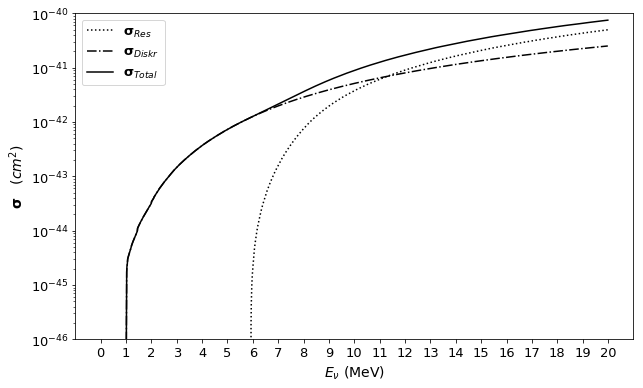

In [57]:
plt.figure(figsize=(10,6))
const = math.pow(10,-44)
plt.plot(Energy_all_fluxes, sigma_36_2border_full * const, ls=':', c='black', 
         label='$\mathbf{\sigma}_{Res}$')
plt.plot(Energy_all_fluxes, np.array(sigma_less5) * const, ls='-.', c='k', 
         label='$\mathbf{\sigma}_{Diskr} $')
plt.plot(Energy_all_fluxes, (np.array(sigma_less5)+sigma_36_2border_full) * const, 
         ls='-', c='k', label='$\mathbf{\sigma}_{Total} $')
plt.xlabel('$E_{\\nu}$ (MeV)', fontsize=14)
plt.ylabel('$\mathbf{\sigma} \quad (cm^2)$', fontsize=14)

plt.yscale('log')
plt.legend(fontsize=13)
#plt.grid(True, which="both",ls="-", color='0.8')
plt.ylim(10**(-46), 10**(-40))
plt.xticks(np.arange(0,21))
plt.tick_params(labelsize=13)
#plt.title('Сечение с учетом только дискретных состояний')

#plt.savefig('cross_section_best_fit_5_Sn_norm19.png', format='png', dpi=500)

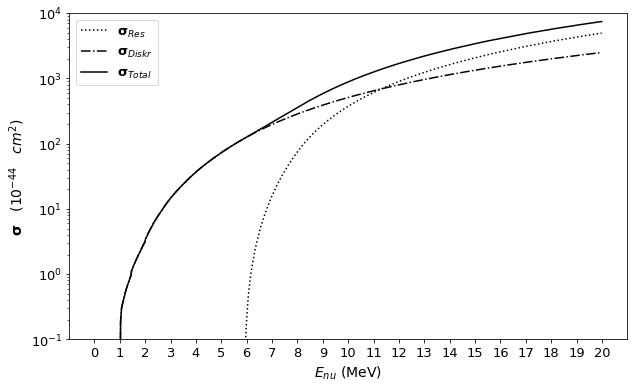

In [58]:
plt.figure(figsize=(10,6))
#plt.plot(Energy_all_fluxes, sigma_best_fit_full, ls=':', c='r', label='cross-section with only best_fit_full')
#plt.plot(Energy_all_fluxes, sigma_best_fit_Sn, ls=':', c='orange', label='cross-section with only best_fit_Sn')
plt.plot(Energy_all_fluxes, sigma_36_2border_full, ls=':', c='black', 
         label='$\mathbf{\sigma}_{Res}$')
plt.plot(Energy_all_fluxes, sigma_less5, ls='-.', c='k', 
         label='$\mathbf{\sigma}_{Diskr} $')
plt.plot(Energy_all_fluxes, sigma_less5+sigma_36_2border_full, ls='-', c='k', 
         label='$\mathbf{\sigma}_{Total} $')
plt.xlabel('$E_{nu}$ (MeV)', fontsize=14)
plt.ylabel('$\mathbf{\sigma} \quad ( 10^{-44} \quad cm^2)$', fontsize=14)

plt.yscale('log')
plt.legend(fontsize=13)
#plt.grid(True, which="both",ls="-", color='0.8')
plt.ylim(10**(-1), 10**(4))
plt.xticks(np.arange(0,21))
plt.tick_params(labelsize=13)
#plt.title('Сечение с учетом только дискретных состояний')

#plt.savefig('cross_section_best_fit_5_Sn_norm19.png', format='png', dpi=500)

In [59]:
rate_calc(sigma_less5)

pp   0.0
B   13.542307922140907
F   0.021059736624544217
O   0.8275492449418691
hep   0.04510635720663797
N   0.10198118176409476
pep   1.3685712782859079
rate_total   15.906575720963959


In [60]:
rate_calc(sigma_36_2border_full)

pp   0.0
B   7.5946627950210095
F   0.0
O   0.0
hep   0.050798981185145774
N   0.0
pep   0.0
rate_total   7.645461776206155


In [61]:
rate_calc(sigma_less5+sigma_36_2border_full)

pp   0.0
B   21.136970717161912
F   0.021059736624544217
O   0.8275492449418691
hep   0.09590533839178372
N   0.10198118176409476
pep   1.3685712782859079
rate_total   23.552037497170115


### with Sn threshold

In [33]:
p_list = np.arange(0,20, 0.1) #p = z - Q

sigma_best_fit_Sn_temp = [cross_sec(0,p, sigma_k_GTR, best_fit['x'].values, y_best_fit_border, 200) for p in p_list]

sigma_best_fit_Sn = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_best_fit_Sn_temp)
#sigma_more5_1 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_more5_temp1)

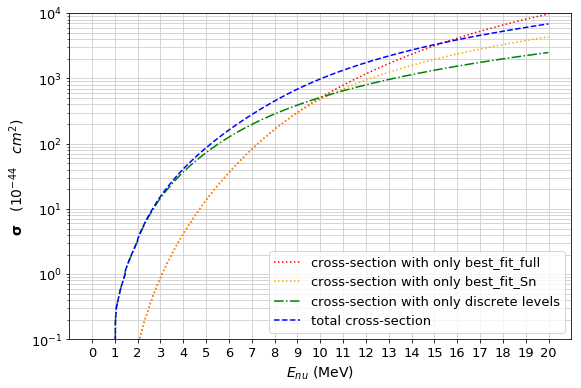

In [34]:
plt.figure(figsize=(9,6))
plt.plot(Energy_all_fluxes, sigma_best_fit_full, ls=':', c='r', label='cross-section with only best_fit_full')
plt.plot(Energy_all_fluxes, sigma_best_fit_Sn, ls=':', c='orange', label='cross-section with only best_fit_Sn')
plt.plot(Energy_all_fluxes, sigma_less5, ls='-.', c='g', label='cross-section with only discrete levels')
plt.plot(Energy_all_fluxes, sigma_less5+sigma_best_fit_Sn, ls='--', c='b', label='total cross-section')
plt.xlabel('$E_{nu}$ (MeV)', fontsize=14)
plt.ylabel('$\mathbf{\sigma} \quad ( 10^{-44} \quad cm^2)$', fontsize=14)
plt.yscale('log')
plt.legend(fontsize=13)
plt.grid(True, which="both",ls="-", color='0.8')
plt.ylim(10**(-1), 10**(4))
plt.xticks(np.arange(0,21))
plt.tick_params(labelsize=13)
#plt.title('Сечение с учетом только дискретных состояний')

#plt.savefig('cross_sections.png', format='png', dpi=500)

In [35]:
rate_calc(sigma_best_fit_Sn)

F   0.00011531451444048166
N   5.926765511503307e-05
O   0.004457849044659912
pp   0.0
hep   0.05301671134971095
B   10.406514263901224
pep   0.008294660645589879
rate_total   10.47245806711074


### with 5 MeV and Sn threshold

In [36]:
p_list = np.arange(0,20, 0.1) #p = z - Q

sigma_best_fit_5_Sn_temp = [cross_sec(0,p, sigma_k_GTR, best_fit['x'].values, y_best_fit_2border, 200) for p in p_list]

sigma_best_fit_5_Sn = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_best_fit_5_Sn_temp)
#sigma_more5_1 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_more5_temp1)

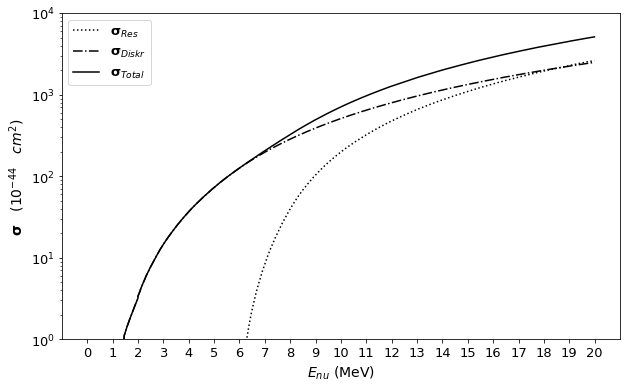

In [37]:
plt.figure(figsize=(10,6))
#plt.plot(Energy_all_fluxes, sigma_best_fit_full, ls=':', c='r', label='cross-section with only best_fit_full')
#plt.plot(Energy_all_fluxes, sigma_best_fit_Sn, ls=':', c='orange', label='cross-section with only best_fit_Sn')
plt.plot(Energy_all_fluxes, sigma_best_fit_5_Sn, ls=':', c='black', 
         label='$\mathbf{\sigma}_{Res}$')
plt.plot(Energy_all_fluxes, sigma_less5, ls='-.', c='k', 
         label='$\mathbf{\sigma}_{Diskr} $')
plt.plot(Energy_all_fluxes, sigma_less5+sigma_best_fit_5_Sn, ls='-', c='k', 
         label='$\mathbf{\sigma}_{Total} $')
plt.xlabel('$E_{nu}$ (MeV)', fontsize=14)
plt.ylabel('$\mathbf{\sigma} \quad ( 10^{-44} \quad cm^2)$', fontsize=14)

plt.yscale('log')
plt.legend(fontsize=13)
#plt.grid(True, which="both",ls="-", color='0.8')
plt.ylim(10**(0), 10**(4))
plt.xticks(np.arange(0,21))
plt.tick_params(labelsize=13)
#plt.title('Сечение с учетом только дискретных состояний')

#plt.savefig('cross_section_best_fit_5_Sn_norm19.png', format='png', dpi=500)

In [38]:
rate_calc(sigma_best_fit_5_Sn)

F   0.0
N   0.0
O   0.0
pp   0.0
hep   0.026951911196706795
B   4.027294546363716
pep   0.0
rate_total   4.054246457560423


In [39]:
rate_calc(sigma_less5+sigma_best_fit_5_Sn)

F   0.021059736624544217
N   0.10198118176409476
O   0.8275492449418691
pp   0.0
hep   0.07205826840334476
B   17.569602468504623
pep   1.3685712782859079
rate_total   19.960822178524385


### with 5 MeV threshold

In [40]:
p_list = np.arange(0,20, 0.1) #p = z - Q

sigma_best_fit_5_temp = [cross_sec(0,p, sigma_k_GTR, best_fit['x'].values, y_best_fit_border5, 200) for p in p_list]

sigma_best_fit_5 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_best_fit_5_temp)
#sigma_more5_1 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_more5_temp1)

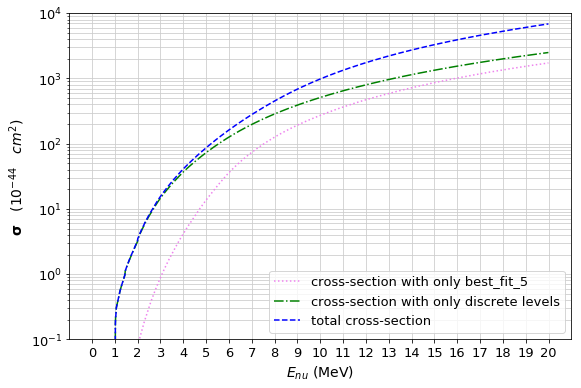

In [41]:
plt.figure(figsize=(9,6))
#plt.plot(Energy_all_fluxes, sigma_best_fit_full, ls=':', c='r', label='cross-section with only best_fit_full')
#plt.plot(Energy_all_fluxes, sigma_best_fit_Sn, ls=':', c='orange', label='cross-section with only best_fit_Sn')
#plt.plot(Energy_all_fluxes, sigma_best_fit_5_Sn, ls=':', c='violet', label='cross-section with only best_fit_5_Sn')
plt.plot(Energy_all_fluxes, sigma_best_fit_5, ls=':', c='violet', label='cross-section with only best_fit_5')
plt.plot(Energy_all_fluxes, sigma_less5, ls='-.', c='g', label='cross-section with only discrete levels')
plt.plot(Energy_all_fluxes, sigma_less5+sigma_best_fit_Sn, ls='--', c='b', label='total cross-section')
plt.xlabel('$E_{nu}$ (MeV)', fontsize=14)
plt.ylabel('$\mathbf{\sigma} \quad ( 10^{-44} \quad cm^2)$', fontsize=14)
plt.yscale('log')
plt.legend(fontsize=13)
plt.grid(True, which="both",ls="-", color='0.8')
plt.ylim(10**(-1), 10**(4))
plt.xticks(np.arange(0,21))
plt.tick_params(labelsize=13)
#plt.title('Сечение с учетом только дискретных состояний')

#plt.savefig('cross_sections.png', format='png', dpi=500)

In [42]:
rate_calc(sigma_best_fit_5)

F   0.00011531451444048166
N   5.926765511503307e-05
O   0.004457849044659912
pp   0.0
hep   0.026064800153004164
B   6.379219717537508
pep   0.008294660645589879
rate_total   6.418211609550317


### work with summ table

In [43]:
energy_bins = np.arange(0.5,5.5,0.5)
bgt_05bin=np.array([0.210,  0.068, 0.351, 0.207, 0.118, 0.255, 0.199, 0.341, 0.323, 0.360])
bgt_05bin_ind_st=np.array([ 0.163, 0.093, 0.335, 0.182, 0.035, 0.199, 0.092, 0.210, 0.154, 0.136])

In [44]:
def get_borders(right_border):
    return [right_border-0.5, right_border]


def get_bin_integral(right_border, x_data, strenght_func):
    borders = get_borders(right_border)
    y_bordered = border_func2(x_data, strenght_func, borders[0], borders[1])
    return trapz(y_bordered, x_data)
        

In [45]:
bgt_05bin_integ=np.array([get_bin_integral(elem, best_fit['x'].values, y_best_fit) for elem in 
                          energy_bins])

In [46]:
energy_bins

array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ])

In [47]:
for elem in energy_bins:print(get_borders(elem))

[0.0, 0.5]
[0.5, 1.0]
[1.0, 1.5]
[1.5, 2.0]
[2.0, 2.5]
[2.5, 3.0]
[3.0, 3.5]
[3.5, 4.0]
[4.0, 4.5]
[4.5, 5.0]


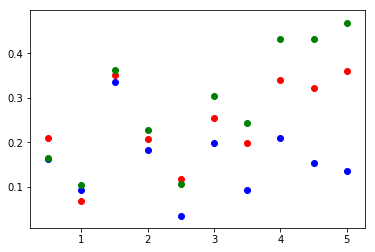

In [48]:
plt.scatter(energy_bins, bgt_05bin, c='r')
plt.scatter(energy_bins, bgt_05bin_ind_st, c='b')
plt.scatter(energy_bins, bgt_05bin_ind_st+bgt_05bin_integ, c='g')

In [49]:
energy_bins.shape

(10,)

# for norm 36 

Text(0.5,0,'Ex')

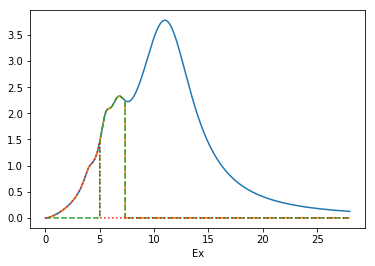

In [50]:
y_best_fit_norm36 = best_fit['y'].values / trapz(best_fit['y'].values, best_fit['x'].values) \
* (36-table_BGT)

y_best_fit_border_norm36 = border_func(best_fit['x'].values, y_best_fit_norm36, S_n)
y_best_fit_2border_norm36 = border_func2(best_fit['x'].values, y_best_fit_norm36, 5, S_n)
y_best_fit_border5_norm36 = border_func(best_fit['x'].values, y_best_fit_norm36, 5)


plt.plot(best_fit['x'].values, y_best_fit_norm36)
plt.plot(best_fit['x'].values, y_best_fit_border_norm36, ls='-.')
plt.plot(best_fit['x'].values, y_best_fit_2border_norm36, ls='--')
plt.plot(best_fit['x'].values, y_best_fit_border5_norm36, ls=':')
plt.xlabel('Ex')

In [51]:
p_list = np.arange(0,20, 0.1) #p = z - Q

#sigma_more5_temp = [ quad(sigma_k_more5, 0, p, args=(p), limit=200)[0] for p in p_list]
#sigma_more5_temp = [ sc.integrate.fixed_quad(sigma_k_more5, 0, p, args=(p, x_norm, y_norm), n=20)[0] for p in p_list]
#sigma_more5_temp = [ sc.integrate.romberg(sigma_k_more5, 0, p, args=(p,)) for p in p_list]
#sigma_more5_temp = [sigma_more5_ab(p) for p in p_list]

sigma_best_fit_full_norm36_temp = [cross_sec(0,p, sigma_k_GTR, best_fit['x'].values,
                                             y_best_fit_norm36, 200) for p in p_list]

sigma_best_fit_full_norm36 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, 
                                       fp=sigma_best_fit_full_norm36_temp)
#sigma_more5_1 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_more5_temp1)

In [52]:
rate_calc(sigma_best_fit_full_norm36)

F   0.00021657456173341532
N   0.00011131180228080125
O   0.008372377994265885
pp   0.0
hep   0.14190580642778772
B   21.764361806553776
pep   0.01557837278995121
rate_total   21.930546250129794


In [53]:
rate_calc(sigma_less5+sigma_best_fit_full_norm36)

F   0.021276311186277635
N   0.10209249356637558
O   0.8359216229361349
pp   0.0
hep   0.18701216363442566
B   35.30666972869467
pep   1.3841496510758589
rate_total   37.837121971093744


### with Sn threshold

In [54]:
p_list = np.arange(0,20, 0.1) #p = z - Q

sigma_best_fit_Sn_norm36_temp = [cross_sec(0,p, sigma_k_GTR, best_fit['x'].values,
                                           y_best_fit_border5_norm36, 200) for p in p_list]

sigma_best_fit_Sn_norm36 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As,
                                     fp=sigma_best_fit_Sn_norm36_temp)
#sigma_more5_1 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_more5_temp1)

In [55]:
rate_calc(sigma_best_fit_Sn_norm36)

F   0.00021657456173341532
N   0.00011131180228080125
O   0.008372377994265885
pp   0.0
hep   0.0489528373526606
B   11.980943779977784
pep   0.01557837278995121
rate_total   12.054175254478675


### with 5 MeV and Sn threshold

In [56]:
p_list = np.arange(0,20, 0.1) #p = z - Q

sigma_best_fit_5_Sn_norm36_temp = [cross_sec(0,p, sigma_k_GTR, best_fit['x'].values,
                                             y_best_fit_2border_norm36, 200) for p in p_list]

sigma_best_fit_5_Sn_norm36 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, 
                                       fp=sigma_best_fit_5_Sn_norm36_temp)
#sigma_more5_1 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_more5_temp1)

In [57]:
rate_calc(sigma_best_fit_5_Sn_norm36)

F   0.0
N   0.0
O   0.0
pp   0.0
hep   0.05061893885281421
B   7.563744733975157
pep   0.0
rate_total   7.614363672827971


In [58]:
rate_calc(sigma_less5)

F   0.021059736624544217
N   0.10198118176409476
O   0.8275492449418691
pp   0.0
hep   0.04510635720663797
B   13.542307922140907
pep   1.3685712782859079
rate_total   15.90657572096396


In [59]:
rate_calc(sigma_less5+sigma_best_fit_5_Sn_norm36)

F   0.021059736624544217
N   0.10198118176409476
O   0.8275492449418691
pp   0.0
hep   0.09572529605945217
B   21.106052656116066
pep   1.3685712782859079
rate_total   23.520939393791934


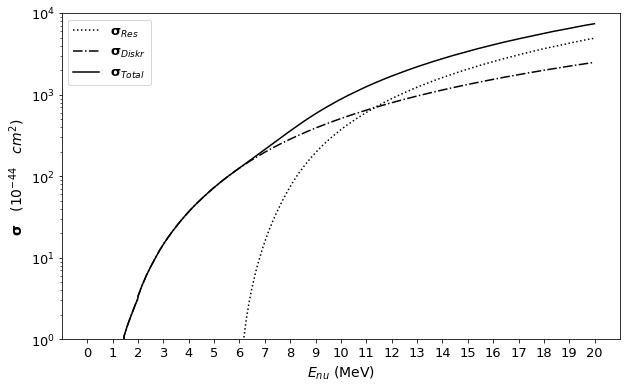

In [60]:
plt.figure(figsize=(10,6))
#plt.plot(Energy_all_fluxes, sigma_best_fit_full, ls=':', c='r', label='cross-section with only best_fit_full')
#plt.plot(Energy_all_fluxes, sigma_best_fit_Sn, ls=':', c='orange', label='cross-section with only best_fit_Sn')
plt.plot(Energy_all_fluxes, sigma_best_fit_5_Sn_norm36, ls=':', c='black', 
         label='$\mathbf{\sigma}_{Res}$')
plt.plot(Energy_all_fluxes, sigma_less5, ls='-.', c='k', 
         label='$\mathbf{\sigma}_{Diskr} $')
plt.plot(Energy_all_fluxes, sigma_less5+sigma_best_fit_5_Sn_norm36, ls='-', c='k', 
         label='$\mathbf{\sigma}_{Total} $')
plt.xlabel('$E_{nu}$ (MeV)', fontsize=14)
plt.ylabel('$\mathbf{\sigma} \quad ( 10^{-44} \quad cm^2)$', fontsize=14)
plt.yscale('log')
plt.legend(fontsize=13)
#plt.grid(True, which="both",ls="-", color='0.8')
plt.ylim(10**(0), 10**(4))
plt.xticks(np.arange(0,21))
plt.tick_params(labelsize=13)
#plt.title('Сечение с учетом только дискретных состояний')

#plt.savefig('cross_section_best_fit_5_Sn_norm36.png', format='png', dpi=500)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


Text(0,0.5,'$\\mathbf{\\sigma} \\quad ( 10^{-44} \\quad cm^2)$')

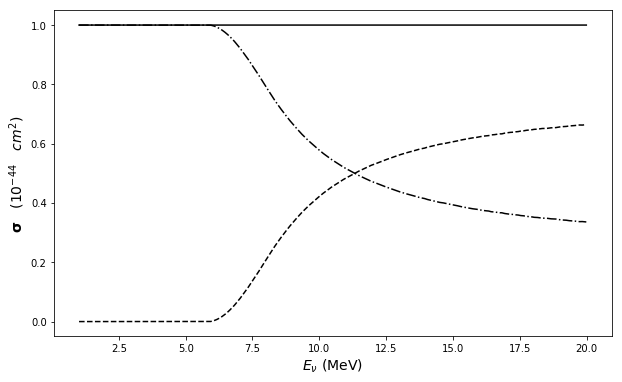

In [61]:
plt.figure(figsize=(10,6))
#plt.plot(Energy_all_fluxes, sigma_best_fit_full, ls=':', c='r', label='cross-section with only best_fit_full')
#plt.plot(Energy_all_fluxes, sigma_best_fit_Sn, ls=':', c='orange', label='cross-section with only best_fit_Sn')
total = sigma_less5+sigma_best_fit_5_Sn_norm36
a = total/total
b = (sigma_less5)/total
c = (sigma_best_fit_5_Sn_norm36)/total

plt.plot(Energy_all_fluxes, a, 
         ls='-', c='black', label='')
plt.plot(Energy_all_fluxes, b, ls='-.', c='k', label='')
plt.plot(Energy_all_fluxes, c, ls='--', c='k', label='')
plt.xlabel('$E_{\\nu}$ (MeV)', fontsize=14)
plt.ylabel('$\mathbf{\sigma} \quad ( 10^{-44} \quad cm^2)$', fontsize=14)
#plt.yscale('log')
#plt.legend(fontsize=13)
#plt.grid(True, which="both",ls="-", color='0.8')
#plt.ylim(10**(0), 10**(4))
#plt.xticks(np.arange(0,21))
#plt.tick_params(labelsize=13)
#plt.title('Сечение с учетом только дискретных состояний')

#plt.savefig('cross_section_best_fit_5_Sn_norm36.png', format='png', dpi=500)

### учет только гтр в виде гаусса

In [72]:
gauss_3pr = pd.read_csv('3pigmy_gauss-SDR-IAS-QFC.csv')
#best_fit = pd.read_csv('2pigmy_best_fit-SDR-IAS-QFC.csv')
gauss_3pr.head()

,Unnamed: 0,GTR_gauss,PR1,PR2,PR3,x,y
0,0,0.000105,0.00000,0.00000,0.00000,0.000000,0.000105
1,1,0.000106,0.00000,0.00000,0.00000,0.005724,0.000106
2,2,0.000107,0.00000,0.00000,0.00000,0.011447,0.000107
3,3,0.000108,0.00001,0.00001,0.00001,0.017171,0.000138
4,4,0.000109,0.00001,0.00001,0.00001,0.022895,0.000139


(0, 6)

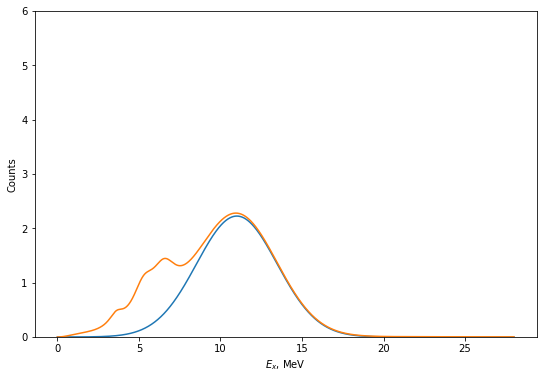

In [74]:
plt.figure(figsize=(9,6))
#plt.plot(best_fit_3pr['x'].values, best_fit_3pr['y'].values)
plt.plot(gauss_3pr['x'].values, gauss_3pr['GTR_gauss'].values)
plt.plot(gauss_3pr['x'].values, gauss_3pr['GTR_gauss'].values+gauss_3pr['PR1'].values+
         gauss_3pr['PR2'].values+gauss_3pr['PR3'].values)

plt.xlabel('$E_x$, MeV')
plt.ylabel('Counts')
plt.ylim(0,6)

Text(0.5,0,'Ex')

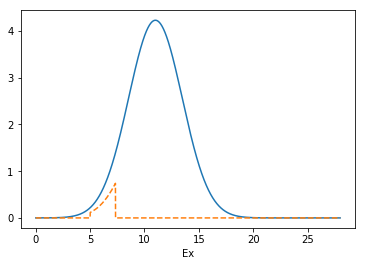

In [75]:
y_GTR_gauss_norm36 = gauss_3pr['GTR_gauss'].values / trapz(gauss_3pr['y'].values, 
                                                 gauss_3pr['x'].values) \
* (36-table_BGT)

y_GTR_gauss_norm19 = gauss_3pr['GTR_gauss'].values / trapz(gauss_3pr['y'].values, 
                                                  gauss_3pr['x'].values) \
* (total_GT-table_BGT)


y_GTR_gauss_2border_norm36 = border_func2(gauss_3pr['x'].values, y_GTR_gauss_norm36, 5, S_n)
y_GTR_gauss_2border_norm19 = border_func2(gauss_3pr['x'].values, y_GTR_gauss_norm19, 5, S_n)

plt.plot(gauss_3pr['x'].values, y_GTR_gauss_norm36)
plt.plot(gauss_3pr['x'].values, y_GTR_gauss_2border_norm19, ls='--')
plt.xlabel('Ex')


In [76]:
#only GTR

p_list = np.arange(0,20, 0.1) #p = z - Q

sigma_GTR_gauss_5_Sn_norm36_temp = [cross_sec(0,p, sigma_k_GTR, gauss_3pr['x'].values,
                                             y_GTR_gauss_2border_norm36, 200) for p in p_list]

sigma_GTR_gauss_5_Sn_norm36 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, 
                                       fp=sigma_GTR_gauss_5_Sn_norm36_temp)
#sigma_more5_1 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_more5_temp1)

rate_calc(sigma_GTR_gauss_5_Sn_norm36)

F   0.0
N   0.0
O   0.0
pp   0.0
hep   0.0149953508076659
B   2.089699801330131
pep   0.0
rate_total   2.104695152137797


In [69]:
#only GTR norm 19

p_list = np.arange(0,20, 0.1) #p = z - Q

sigma_GTR_5_Sn_norm19_temp = [cross_sec(0,p, sigma_k_GTR, best_fit_3pr['x'].values,
                                             y_GTR_2border_norm19, 200) for p in p_list]

sigma_GTR_5_Sn_norm19 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, 
                                       fp=sigma_GTR_5_Sn_norm19_temp)
#sigma_more5_1 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_more5_temp1)

#PR1
sigma_PR1_5_Sn_norm19_temp = [cross_sec(0,p, sigma_k_GTR, best_fit_3pr['x'].values,
                                             y_PR1_2border_norm19, 200) for p in p_list]
sigma_PR1_5_Sn_norm19 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, 
                                       fp=sigma_PR1_5_Sn_norm19_temp)

#PR2
sigma_PR2_5_Sn_norm19_temp = [cross_sec(0,p, sigma_k_GTR, best_fit_3pr['x'].values,
                                             y_PR2_2border_norm19, 200) for p in p_list]
sigma_PR2_5_Sn_norm19 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, 
                                       fp=sigma_PR2_5_Sn_norm19_temp)

#PR3
sigma_PR3_5_Sn_norm19_temp = [cross_sec(0,p, sigma_k_GTR, best_fit_3pr['x'].values,
                                             y_PR3_2border_norm19, 200) for p in p_list]
sigma_PR3_5_Sn_norm19 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, 
                                       fp=sigma_PR3_5_Sn_norm19_temp)

In [70]:
print('norm 19')
print('\n', 'GTR')
rate_calc(sigma_GTR_5_Sn_norm19)
print('\n', 'PR1')
rate_calc(sigma_PR1_5_Sn_norm19)
print('\n', 'PR2')
rate_calc(sigma_PR2_5_Sn_norm19)
print('\n', 'PR3')
rate_calc(sigma_PR3_5_Sn_norm19)
print('\n', 'PR3+PR2+PR1')
rate_calc(sigma_PR3_5_Sn_norm19+sigma_PR2_5_Sn_norm19+sigma_PR1_5_Sn_norm19)
print('\n', 'GTR+PR3+PR2+PR1')
rate_calc(sigma_GTR_5_Sn_norm19+sigma_PR3_5_Sn_norm19+sigma_PR2_5_Sn_norm19+
          sigma_PR1_5_Sn_norm19)

norm 19

 GTR
F   0.0
N   0.0
O   0.0
pp   0.0
hep   0.013614311516791556
B   1.9978737969624663
pep   0.0
rate_total   2.011488108479258

 PR1
F   0.0
N   0.0
O   0.0
pp   0.0
hep   0.00034703027143177323
B   0.05739768228941365
pep   0.0
rate_total   0.05774471256084542

 PR2
F   0.0
N   0.0
O   0.0
pp   0.0
hep   0.005593910285420234
B   0.9114735034903468
pep   0.0
rate_total   0.9170674137757671

 PR3
F   0.0
N   0.0
O   0.0
pp   0.0
hep   0.007396659123063229
B   1.06054956362149
pep   0.0
rate_total   1.0679462227445533

 PR3+PR2+PR1
F   0.0
N   0.0
O   0.0
pp   0.0
hep   0.013337599679915237
B   2.0294207494012504
pep   0.0
rate_total   2.042758349081166

 GTR+PR3+PR2+PR1
F   0.0
N   0.0
O   0.0
pp   0.0
hep   0.026951911196706795
B   4.027294546363716
pep   0.0
rate_total   4.054246457560423


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


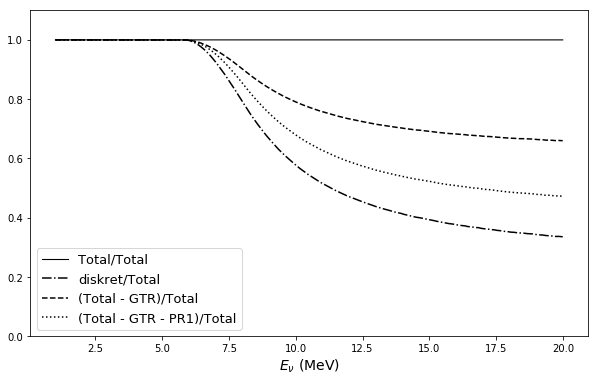

In [71]:
plt.figure(figsize=(10,6))
#plt.plot(Energy_all_fluxes, sigma_best_fit_full, ls=':', c='r', label='cross-section with only best_fit_full')
#plt.plot(Energy_all_fluxes, sigma_best_fit_Sn, ls=':', c='orange', label='cross-section with only best_fit_Sn')
total = sigma_less5+sigma_GTR_5_Sn_norm36+sigma_PR1_5_Sn_norm36+sigma_PR2_5_Sn_norm36+\
sigma_PR3_5_Sn_norm36

a = total/total
b = (sigma_less5)/total
c = (total-sigma_GTR_5_Sn_norm36)/total
d = (total-sigma_GTR_5_Sn_norm36-sigma_PR3_5_Sn_norm36)/total
e = (total-sigma_GTR_5_Sn_norm36-sigma_PR3_5_Sn_norm36-sigma_PR2_5_Sn_norm36)/total

plt.plot(Energy_all_fluxes, a, 
         ls='-', c='black', label='Total/Total', linewidth=1.1, )
plt.plot(Energy_all_fluxes, b, ls='-.', c='k', label='diskret/Total')
plt.plot(Energy_all_fluxes, c, ls='--', c='k', label='(Total - GTR)/Total')
plt.plot(Energy_all_fluxes, d, ls=':', c='k', label='(Total - GTR - PR1)/Total')
plt.xlabel('$E_{\\nu}$ (MeV)', fontsize=14)
plt.ylim(0,1.1)
plt.legend(fontsize=13)
#plt.ylabel('$\mathbf{\sigma} \quad ( 10^{-44} \quad cm^2)$', fontsize=14)
#plt.yscale('log')
#plt.legend(fontsize=13)
#plt.grid(True, which="both",ls="-", color='0.8')
#plt.ylim(10**(0), 10**(4))
#plt.xticks(np.arange(0,21))
#plt.tick_params(labelsize=13)
#plt.title('Сечение с учетом только дискретных состояний')

plt.savefig('отношение_сечений_norm36.png', format='png', dpi=500)

### учет только гтр

In [62]:
best_fit_3pr = pd.read_csv('best_fit_3PR-SDR-IAS-QFC.csv')
#best_fit = pd.read_csv('2pigmy_best_fit-SDR-IAS-QFC.csv')
best_fit_3pr.head()

,Unnamed: 0,GTR,PR1,PR2,PR3,x,y
0,0,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000
1,1,0.00000,0.00000,0.00000,0.00000,0.005724,0.00000
2,2,0.00000,0.00000,0.00000,0.00000,0.011447,0.00000
3,3,0.00001,0.00000,0.00000,0.00000,0.017171,0.00001
4,4,0.00001,0.00001,0.00001,0.00001,0.022895,0.00004


(0, 6)

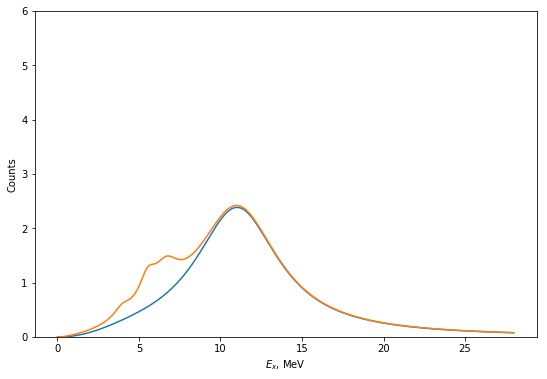

In [63]:
plt.figure(figsize=(9,6))
#plt.plot(best_fit_3pr['x'].values, best_fit_3pr['y'].values)
plt.plot(best_fit_3pr['x'].values, best_fit_3pr['GTR'].values)
plt.plot(best_fit_3pr['x'].values, best_fit_3pr['GTR'].values+best_fit_3pr['PR1'].values+
         best_fit_3pr['PR2'].values+best_fit_3pr['PR3'].values)

plt.xlabel('$E_x$, MeV')
plt.ylabel('Counts')
plt.ylim(0,6)

Text(0.5,0,'Ex')

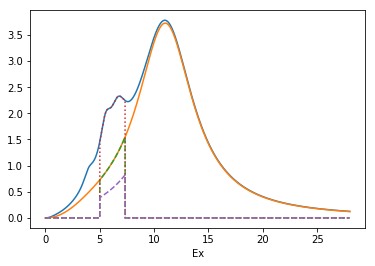

In [64]:
y_GTR_norm36 = best_fit_3pr['GTR'].values / trapz(best_fit_3pr['y'].values, 
                                                 best_fit_3pr['x'].values) \
* (36-table_BGT)

PR_total = best_fit_3pr['PR1'].values+best_fit_3pr['PR2'].values+best_fit_3pr['PR3'].values
y_PR_norm36 = PR_total / trapz(best_fit_3pr['y'].values, best_fit_3pr['x'].values) \
* (36-table_BGT)

y_PR1_norm36 = best_fit_3pr['PR1'].values / trapz(best_fit_3pr['y'].values, 
                                                  best_fit_3pr['x'].values) \
* (36-table_BGT)

y_PR2_norm36 = best_fit_3pr['PR2'].values / trapz(best_fit_3pr['y'].values, 
                                                  best_fit_3pr['x'].values) \
* (36-table_BGT)

y_PR3_norm36 = best_fit_3pr['PR3'].values / trapz(best_fit_3pr['y'].values, 
                                                  best_fit_3pr['x'].values) \
* (36-table_BGT)





y_GTR_norm19 = best_fit_3pr['GTR'].values / trapz(best_fit_3pr['y'].values, 
                                                  best_fit_3pr['x'].values) \
* (total_GT-table_BGT)

y_PR1_norm19 = best_fit_3pr['PR1'].values / trapz(best_fit_3pr['y'].values, 
                                                  best_fit_3pr['x'].values) \
* (total_GT-table_BGT)

y_PR2_norm19 = best_fit_3pr['PR2'].values / trapz(best_fit_3pr['y'].values, 
                                                  best_fit_3pr['x'].values) \
* (total_GT-table_BGT)

y_PR3_norm19 = best_fit_3pr['PR3'].values / trapz(best_fit_3pr['y'].values, 
                                                  best_fit_3pr['x'].values) \
* (total_GT-table_BGT)


y_GTR_2border_norm36 = border_func2(best_fit_3pr['x'].values, y_GTR_norm36, 5, S_n)
y_PR_2border_norm36 = border_func2(best_fit_3pr['x'].values, y_PR_norm36, 5, S_n)
y_PR1_2border_norm36 = border_func2(best_fit_3pr['x'].values, y_PR1_norm36, 5, S_n)
y_PR2_2border_norm36 = border_func2(best_fit_3pr['x'].values, y_PR2_norm36, 5, S_n)
y_PR3_2border_norm36 = border_func2(best_fit_3pr['x'].values, y_PR3_norm36, 5, S_n)


y_GTR_2border_norm19 = border_func2(best_fit_3pr['x'].values, y_GTR_norm19, 5, S_n)
y_PR1_2border_norm19 = border_func2(best_fit_3pr['x'].values, y_PR1_norm19, 5, S_n)
y_PR2_2border_norm19 = border_func2(best_fit_3pr['x'].values, y_PR2_norm19, 5, S_n)
y_PR3_2border_norm19 = border_func2(best_fit_3pr['x'].values, y_PR3_norm19, 5, S_n)



plt.plot(best_fit['x'].values, y_best_fit_norm36)
plt.plot(best_fit['x'].values, y_GTR_norm36)
plt.plot(best_fit['x'].values, y_GTR_2border_norm36, ls='--')
plt.plot(best_fit['x'].values, y_GTR_2border_norm36+y_PR_2border_norm36, ls=':')

#plt.plot(best_fit['x'].values, y_best_fit, ls='--')
#plt.plot(best_fit['x'].values, y_GTR_norm19, ls='--')
plt.plot(best_fit['x'].values, y_GTR_2border_norm19, ls='--')
plt.xlabel('Ex')


In [65]:
#only GTR

p_list = np.arange(0,20, 0.1) #p = z - Q

sigma_GTR_5_Sn_norm36_temp = [cross_sec(0,p, sigma_k_GTR, best_fit_3pr['x'].values,
                                             y_GTR_2border_norm36, 200) for p in p_list]

sigma_GTR_5_Sn_norm36 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, 
                                       fp=sigma_GTR_5_Sn_norm36_temp)
#sigma_more5_1 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_more5_temp1)

rate_calc(sigma_GTR_5_Sn_norm36)

F   0.0
N   0.0
O   0.0
pp   0.0
hep   0.02556931852297884
B   3.7522478768199465
pep   0.0
rate_total   3.7778171953429256
